In [1]:
import datetime



import holidays
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import rcParams  # Used to set default paremeters
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
sns.set_style("whitegrid")


# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Load data

UK Energy consumption from the year 2009 to 2024. Fetched this dataset from Kaggle

In [3]:
df = pd.read_csv(
    "historic_demand_2009_2024.csv"
)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

<a id='eda'></a>
# Exploratory Data Analysis






In [4]:
df.sample(n=7)

,unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
118549,118549,2015-10-06,24,37184,38204,33738,1124,3984,2120,8920,...,0,997,-187,-324,0,NaN,NaN,NaN,NaN,0
242741,242741,2022-11-06,6,19164,20502,17865,1784,6545,0,13861,...,-20,725,256,2,50,1246.0,190.0,NaN,NaN,0
41185,41185,2011-05-09,4,23175,24803,20931,659,1786,0,163,...,0,0,-25,0,0,NaN,NaN,NaN,NaN,0
230050,230050,2022-02-14,35,40596,41994,37254,2473,6527,6,13710,...,753,944,-424,-366,1018,1048.0,0.0,NaN,NaN,0
199606,199606,2020-05-21,25,22178,22781,19694,1116,6527,8850,13080,...,0,853,-88,-11,851,0.0,0.0,NaN,NaN,0
128549,128549,2016-05-01,44,29833,30384,27468,1876,4260,0,9602,...,0,988,-38,-3,0,NaN,NaN,NaN,NaN,0
116279,116279,2015-08-20,3,22886,24755,20880,778,3977,0,8814,...,0,908,157,151,0,NaN,NaN,NaN,NaN,0


In [5]:
df.shape

(267168, 23)

In [6]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [7]:
df.isna().any()

unnamed: 0                   False
settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
is_holiday                   False
dtype: bool

In [8]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [9]:
df1=df.copy(deep=True)

In [10]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


We can proceed since bank holidays for England and wales are same

In [11]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(pd.to_datetime(date))

holiday_dates_observed[:5]

[Timestamp('2009-01-01 00:00:00'),
 Timestamp('2009-04-10 00:00:00'),
 Timestamp('2009-04-13 00:00:00'),
 Timestamp('2009-05-04 00:00:00'),
 Timestamp('2009-05-25 00:00:00')]

compare the `holiday_dates` variable and the date in the dataset and store the boolean output in a new column: 

In [12]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,is_holiday
4764,4764,2009-04-10,15,28403,28939,25388,1098,1613,0,0,...,8,1780,0,0,-28,0,0,NaN,NaN,1
34800,34804,2010-12-27,5,33119,34877,29658,1238,2141,0,77,...,757,887,0,0,-401,0,0,NaN,NaN,1
122375,122389,2015-12-25,38,29097,29731,26159,1914,4013,0,9063,...,14,1696,0,1019,-20,131,0,NaN,NaN,1
186695,186715,2019-08-26,46,26102,27451,23516,491,6182,0,13080,...,11,1799,0,0,-305,-533,336,NaN,NaN,1
57203,57209,2012-04-06,44,35063,35985,31651,291,2019,0,1443,...,10,997,0,994,-412,0,0,NaN,NaN,1
146043,146061,2017-05-01,46,28021,28527,25382,1047,5108,0,12000,...,6,1996,0,717,147,0,0,NaN,NaN,1
204485,204507,2020-08-31,30,23778,24338,21109,559,6527,4640,13080,...,6,192,0,0,-54,0,148,NaN,NaN,1


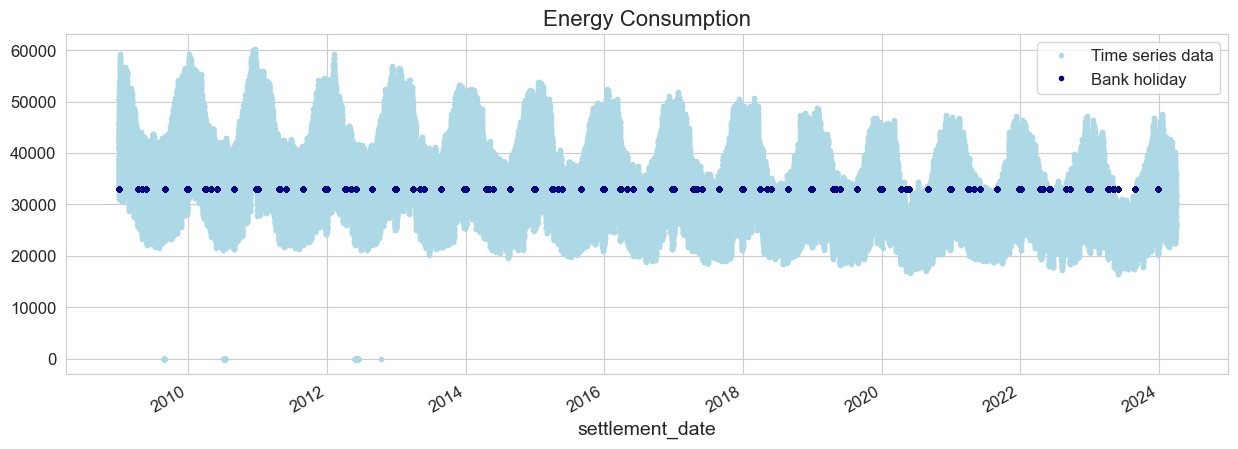

In [13]:


df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)


fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Energy Consumption", label="Time series data", color="#ADD8E6"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday", color="#000080"
)
ax.legend()

plt.show()



### Outlier analysis


<Axes: xlabel='tsd', ylabel='Count'>

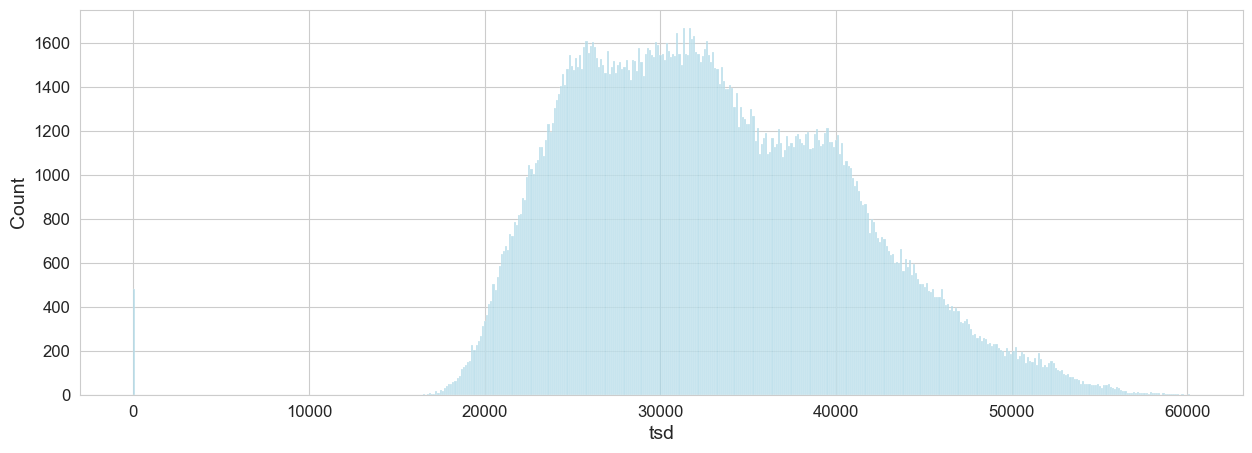

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="#ADD8E6")

Removing Outliers

In [15]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

### Descriptive analysis


In [16]:
from scipy import stats
# Calculate descriptive statistics
mean_value = df['tsd'].mean()
median_value = df['tsd'].median()
mode_value = stats.mode(df['tsd'])[0][0]
range_value = df['tsd'].max() - df['tsd'].min()
iqr_value = np.percentile(df['tsd'], 75) - np.percentile(df['tsd'], 25)
min_value = df['tsd'].min()
max_value = df['tsd'].max()

# Print descriptive statistics
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value:.2f}")
print(f"Mode: {mode_value:.2f}")
print(f"Range: {range_value:.2f}")
print(f"IQR: {iqr_value:.2f}")
print(f"Minimum: {min_value:.2f}")
print(f"Maximum: {max_value:.2f}")

Mean: 32961.85
Median: 32127.00
Mode: 32717.00
Range: 43634.00
IQR: 11471.00
Minimum: 16513.00
Maximum: 60147.00


C:\Users\Kesav S J\AppData\Local\Temp\ipykernel_22080\62339339.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_value = stats.mode(df['tsd'])[0][0]


In [17]:
from scipy import stats
# Calculate descriptive statistics
mean_value = df['tsd'].mean()
median_value = df['tsd'].median()
mode_value = stats.mode(df['tsd'])[0][0]
range_value = df['tsd'].max() - df['tsd'].min()
iqr_value = np.percentile(df['tsd'], 75) - np.percentile(df['tsd'], 25)
min_value = df['tsd'].min()
max_value = df['tsd'].max()

# Print descriptive statistics
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value:.2f}")
print(f"Mode: {mode_value:.2f}")
print(f"Range: {range_value:.2f}")
print(f"IQR: {iqr_value:.2f}")
print(f"Minimum: {min_value:.2f}")
print(f"Maximum: {max_value:.2f}")

Mean: 32961.85
Median: 32127.00
Mode: 32717.00
Range: 43634.00
IQR: 11471.00
Minimum: 16513.00
Maximum: 60147.00


C:\Users\Kesav S J\AppData\Local\Temp\ipykernel_22080\62339339.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_value = stats.mode(df['tsd'])[0][0]


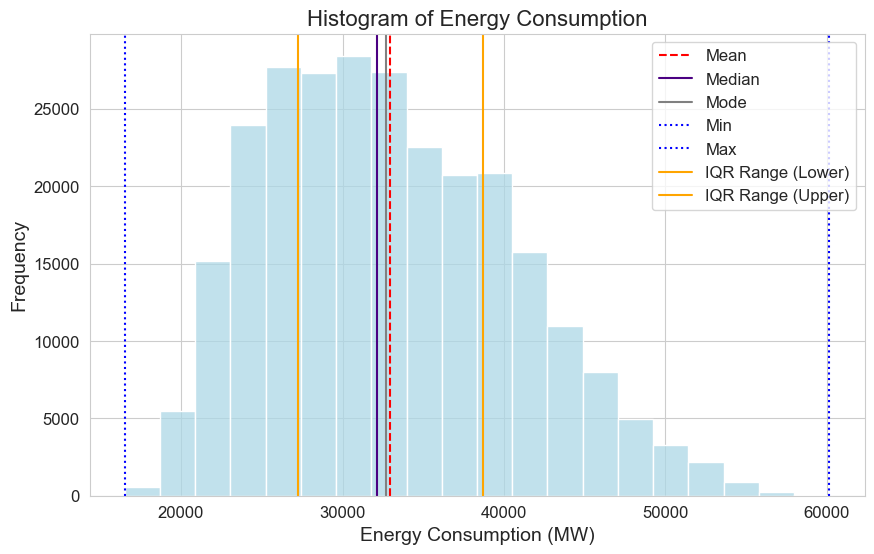

In [18]:
# Create a histogram chart of energy consumption
plt.figure(figsize=(10, 6))
sns.histplot(df['tsd'], kde=False, bins=20, color='#ADD8E6')

# Add vertical lines for mean, median, mode, IQR, range, min, and max
plt.axvline(mean_value, color='red', linestyle='--', label='Mean')
plt.axvline(median_value, color='indigo', linestyle='-', label='Median')
plt.axvline(mode_value, color='gray', linestyle='-', label='Mode')
plt.axvline(min_value, color='blue', linestyle=':', label='Min')
plt.axvline(max_value, color='blue', linestyle=':', label='Max')
plt.axvline(mean_value - iqr_value/2, color='orange', linestyle='-', label='IQR Range (Lower)')
plt.axvline(mean_value + iqr_value/2, color='orange', linestyle='-', label='IQR Range (Upper)')

# Add labels and title
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.title('Histogram of Energy Consumption')
plt.legend()

# Save the visualization
plt.savefig('energy_consumption_histogram.png')

# Display the chart
plt.show()

## Feature creation

`settlement_period` values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day.

In [19]:
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,unnamed: 0,settlement_date,period_hour,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,...,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,is_holiday
191515,192257,2019-12-20,8:30:00,18,39305,40905,36128,1345,6465,9,...,11,1998,0,995,-454,-535,999,NaN,NaN,0
103667,104399,2014-12-15,23:30:00,48,30821,32401,28112,1370,4039,0,...,717,1654,0,1003,-82,-181,0,NaN,NaN,0
260580,261330,2023-11-28,9:00:00,19,37275,38850,33568,710,6488,1791,...,13,691,-2,618,-452,-508,776,20.0,0.0,0
30426,30716,2010-10-02,23:00:00,47,28421,28979,25620,1407,2121,0,...,13,1345,0,0,-45,0,0,NaN,NaN,0
29807,30097,2010-09-20,1:30:00,4,22685,24470,20461,1368,2092,0,...,1265,1098,0,0,-20,0,0,NaN,NaN,0
106564,107305,2015-02-14,8:00:00,17,35090,35891,31872,664,4087,150,...,12,1994,0,1000,-30,-159,0,NaN,NaN,0
201035,201777,2020-07-05,17:30:00,36,23028,25415,20852,4378,6527,3330,...,15,-1377,0,-495,93,504,418,NaN,NaN,0


A new column called `period_hour` includes the hour at which the electricity demand measurement was taken.

In [20]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,unnamed: 0,settlement_date,period_hour,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,...,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,is_holiday
157594,158333,2018-01-12 14:00:00,14:00:00,29,42217,42840,38746,1701,5779,756,...,6,1997,0,999,-17,207,0,NaN,NaN,0
67372,68101,2012-11-19 18:00:00,18:00:00,37,49416,50381,45012,1375,2085,2,...,15,993,0,994,-251,-250,0,NaN,NaN,0
260752,261502,2023-12-01 23:00:00,23:00:00,47,30829,32395,27909,323,6488,0,...,6,694,-4,186,-452,-504,346,-1127.0,0.0,0
38209,38501,2011-03-14 02:30:00,2:30:00,6,30609,33055,27598,220,1737,0,...,1530,819,0,0,-316,0,0,NaN,NaN,0
69588,70316,2013-01-04 22:00:00,22:00:00,45,35453,36560,32348,595,2085,0,...,13,993,0,993,-251,-251,0,NaN,NaN,0


The `settlement_date` column is now in the right format to use an index:

<Axes: xlabel='settlement_date', ylabel='Electricity demand (MW)'>

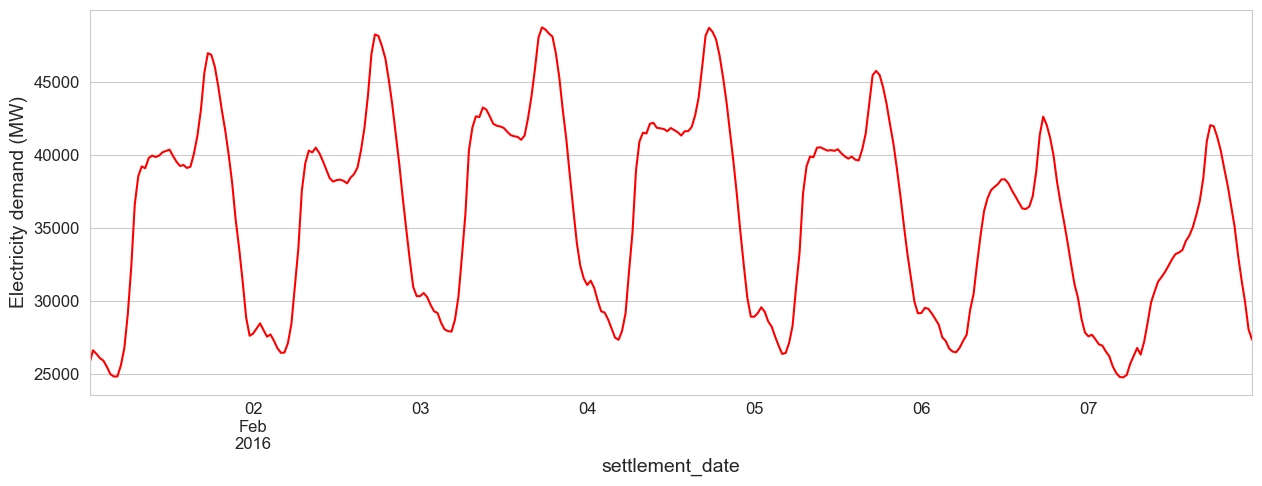

In [21]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "02-01-2016") & (df.index < "02-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)", color="red"
)

#remove

In [22]:
df1["settlement_date"] = pd.to_datetime(df1["settlement_date"])

# Extract year from 'Settlement Date'
df1["Year"] = df1["settlement_date"].dt.year

# Group by year and calculate the sum of the other columns
df_grouped = (
    df1[["tsd", "embedded_solar_capacity", "embedded_wind_capacity", "Year"]]
    .groupby("Year")
    .sum()
)

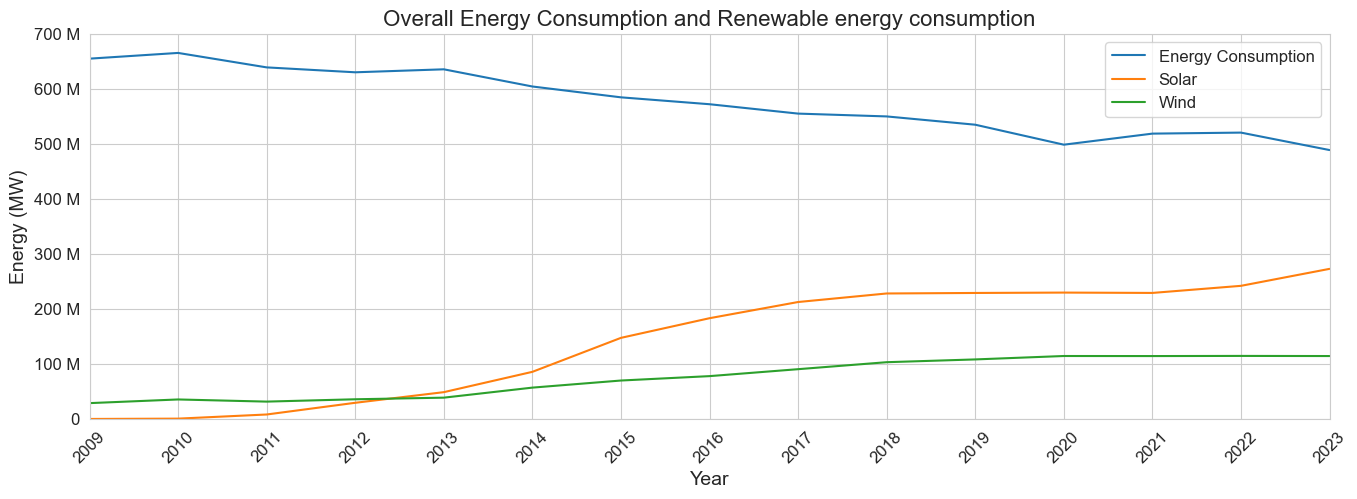

In [24]:
import matplotlib.ticker as ticker

df_plot = df_grouped
df_plot.index = df_grouped.index
df_plot = df_plot.iloc[:-1]

fig, ax = plt.subplots(figsize=(16, 5))
df_plot["tsd"].plot(ax=ax, title="Trasnmission System Demand", label="Energy Consumption")
df_plot["embedded_solar_capacity"].plot(
    ax=ax, title="Trasnmission System Demand", label="Solar"
)
df_plot["embedded_wind_capacity"].plot(
    ax=ax, title="Trasnmission System Demand", label="Wind"
)
ax.legend()



# Add title and labels
plt.title("Overall Energy Consumption and Renewable energy consumption")
plt.xlabel("Year")
plt.ylabel("Energy (MW)")
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_xlim(df_plot.index[0], df_plot.index[-1])
ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot.index, rotation=45)
ax.set_ylim(0, 700000000)
plt.savefig("energy_consumption_generation.png", dpi=300, bbox_inches="tight")
plt.show()

## Feature creation

In [25]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [26]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,unnamed: 0,period_hour,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2016-06-20 02:00:00,130908,2:00:00,5,18581,20433,17058,2086,4260,0,10500,...,20,0,172,2,6,2016,25,22641.0,23697.0,22888.0
2015-10-20 11:00:00,119220,11:00:00,23,37029,38747,33363,551,4013,3290,8943,...,20,1,293,4,10,2015,43,36953.0,41727.0,42856.0
2020-06-01 01:30:00,200113,1:30:00,4,18379,18958,16637,1102,6527,0,13080,...,1,0,153,2,6,2020,23,20754.0,22486.0,21031.0
2010-06-20 01:00:00,25680,1:00:00,3,22899,23972,20592,1165,2056,0,29,...,20,6,171,2,6,2010,24,25860.0,NaN,NaN
2020-08-05 11:30:00,203253,11:30:00,24,25607,26604,22991,1944,6527,5300,13080,...,5,2,218,3,8,2020,32,28645.0,29259.0,32111.0


## Feature understanding


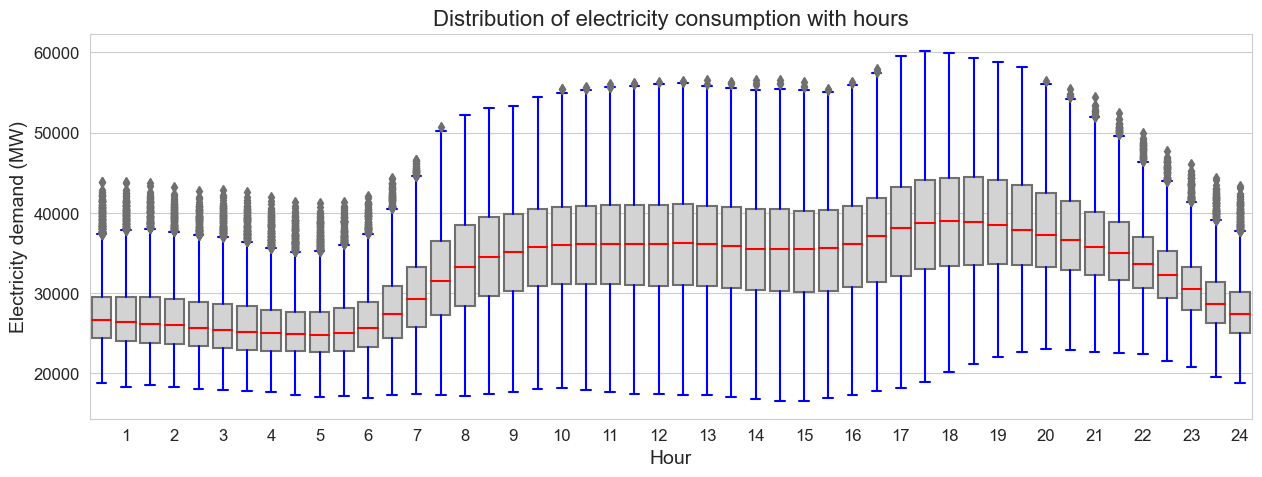

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df, color='skyblue', boxprops=dict(facecolor='lightgrey'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'), medianprops=dict(color='red'))
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours")
plt.savefig("electricity_consumption_distribution_by_hours.png", dpi=300, bbox_inches="tight")
plt.show()


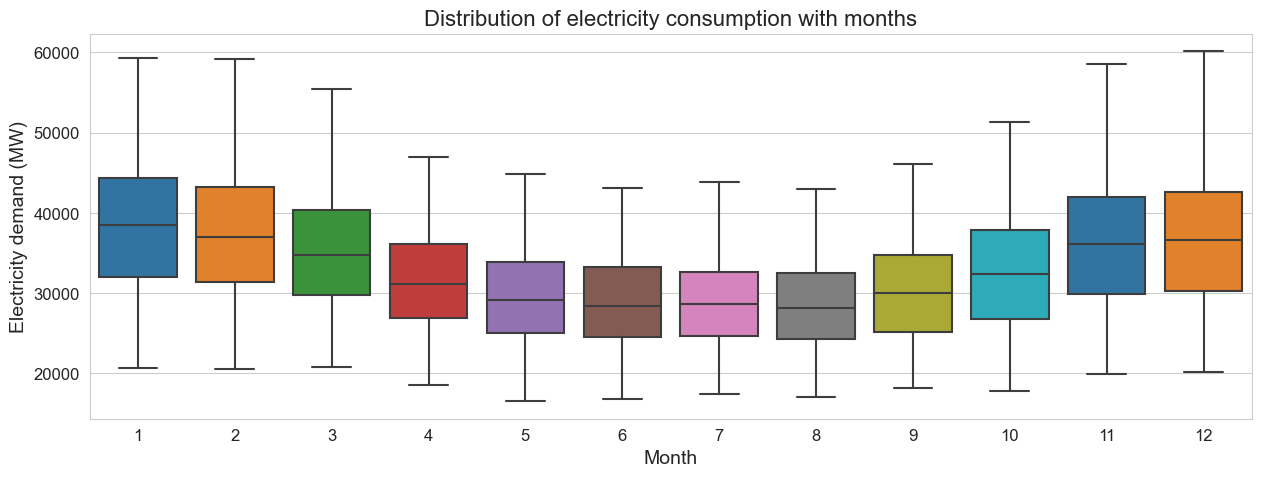

In [30]:
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df, palette=custom_palette)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months")
plt.savefig("electricity_consumption_distribution_by_months.png", dpi=300, bbox_inches="tight")
plt.show()

<Axes: xlabel='settlement_date', ylabel='Electricity demand (MW)'>

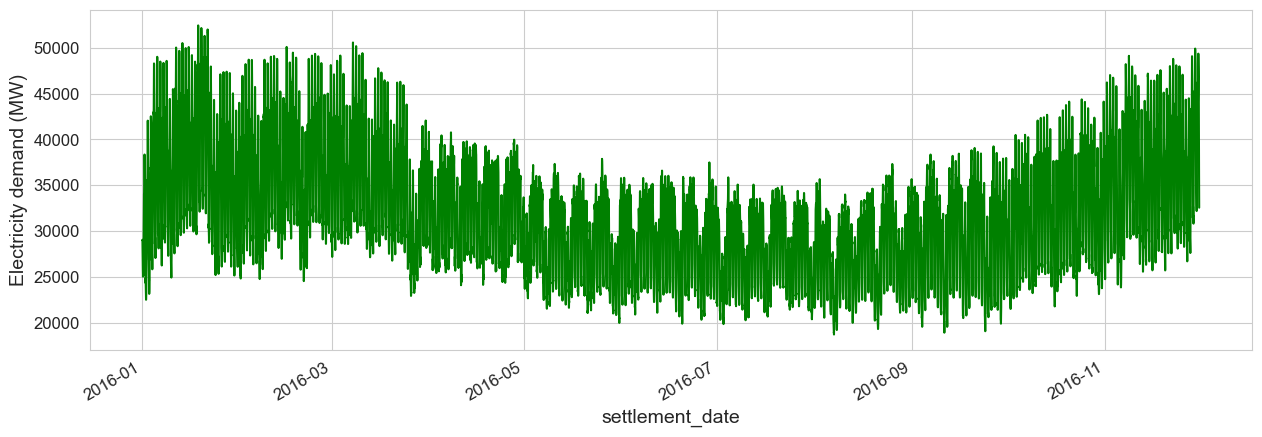

In [31]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)", color="green"
)
#remove

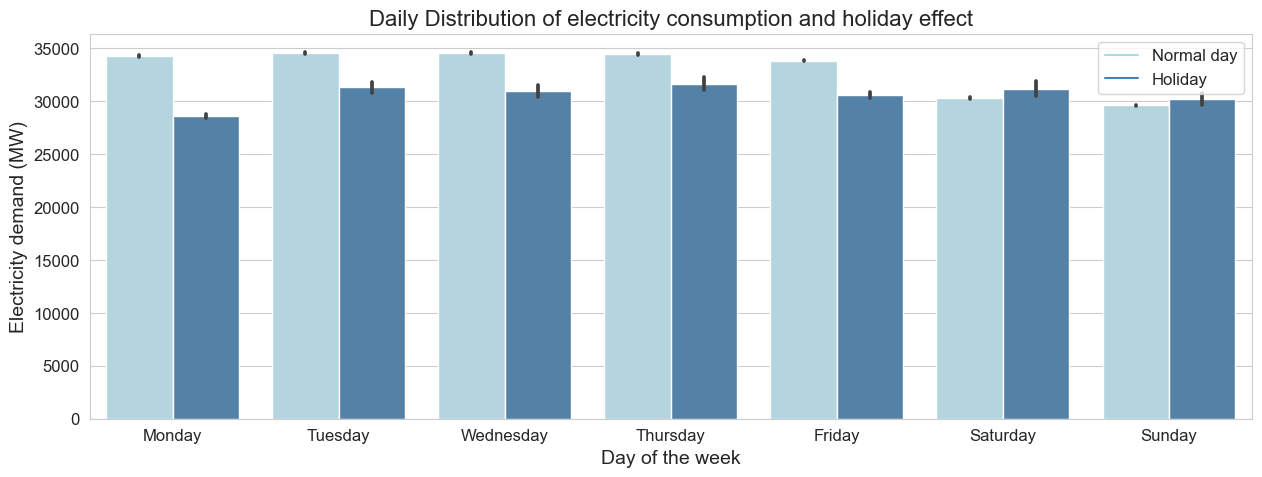

In [38]:
custom_palette = ["#ADD8E6", "#4682B4"]

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", palette=custom_palette, ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect")

# Remove the legend title
ax.legend(title='')

# Set legend labels
normal_day_patch = plt.Line2D([], [], color=custom_palette[0], label='Normal day')
holiday_patch = plt.Line2D([], [], color=custom_palette[1], label='Holiday')
ax.legend(handles=[normal_day_patch, holiday_patch], loc="upper right")
plt.savefig("holiday_effect.png", dpi=300, bbox_inches="tight")
plt.show()
#Label holiday or not

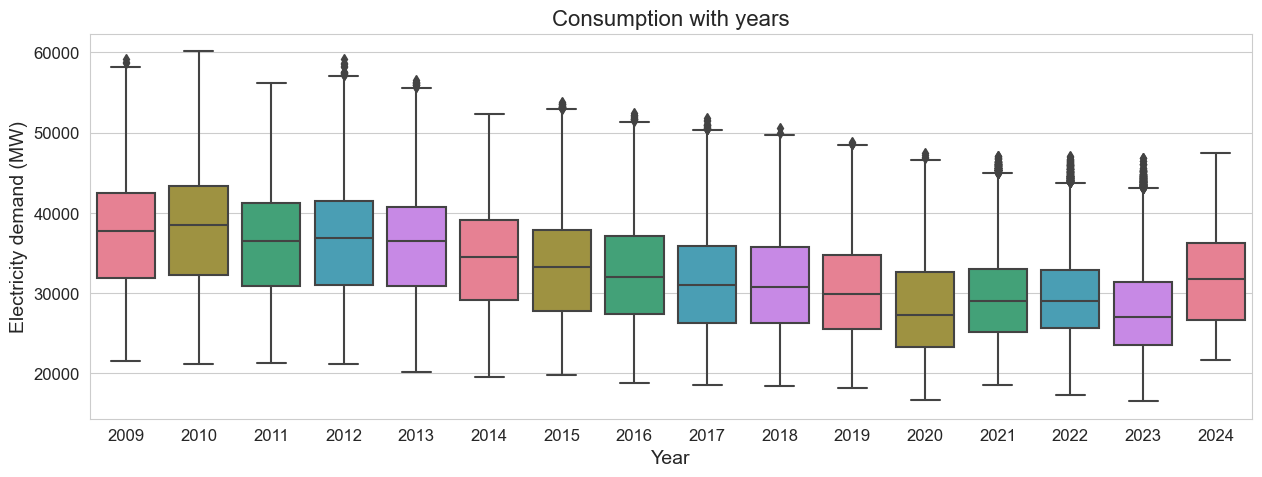

In [39]:
custom_palette = sns.color_palette("husl", 5)  # Adjust the number of colors as needed

# Create the boxplot with the custom color palette
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df, palette=custom_palette)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Consumption with years")
plt.savefig("electricity_consumption_distribution_with_years.png", dpi=300, bbox_inches="tight")
plt.show()

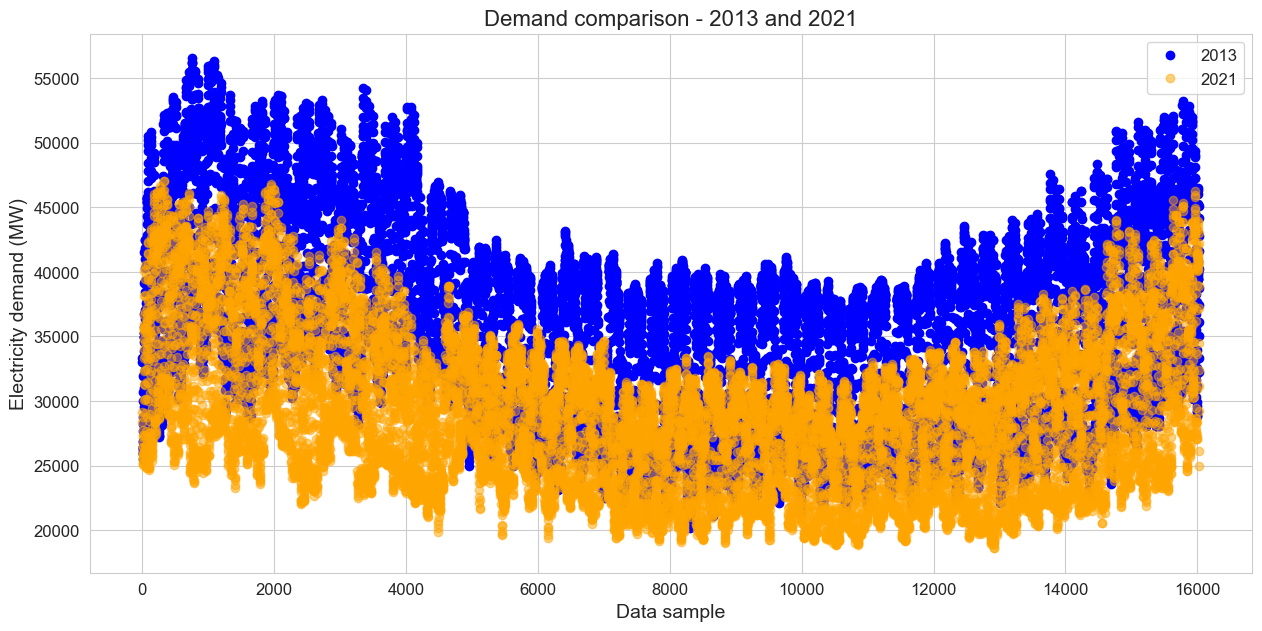

In [40]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
    color='blue'  # Change color to blue
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
    color='orange'  # Change color to orange
)

ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021")
plt.show()

Consumption is decreasing in recent years.

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


### Simple XGBoost model

In [42]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

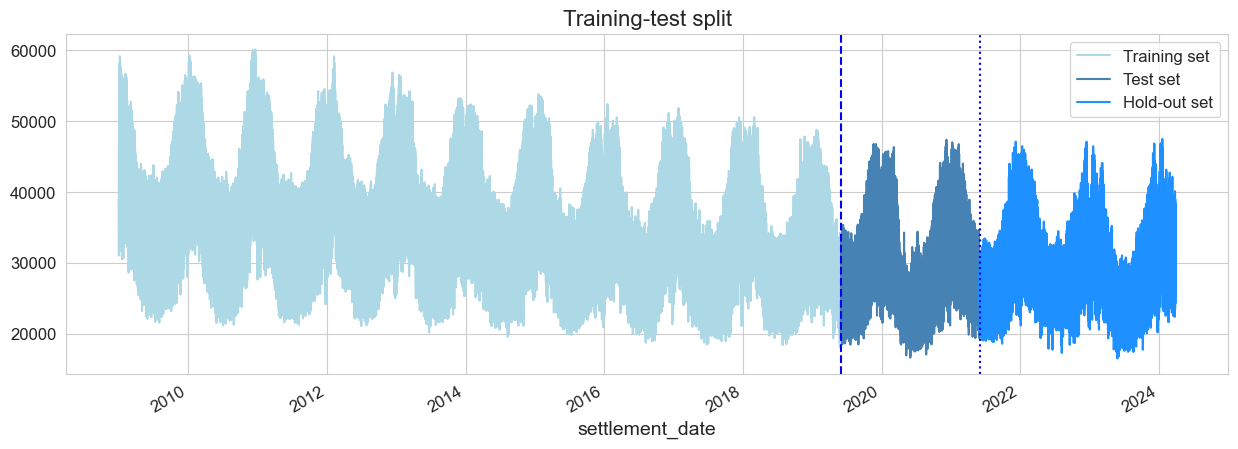

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set", color="#ADD8E6")
test_data["tsd"].plot(ax=ax, label="Test set", color="#4682B4")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set", color="#1E90FF")
ax.axvline(threshold_date_1, color="blue", ls="--")  #Change color to red
ax.axvline(threshold_date_2, color="blue", ls=":")  #Change color to blue
ax.set_title("Training-test split")
plt.legend()
plt.savefig("Training_test_split.png", dpi=300, bbox_inches="tight")
plt.show()

In [52]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    #     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
)

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8038.78338
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6197.64526
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5237.86904
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4643.09745
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4270.44551
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4038.10014


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=43, ...)

#### Feature importance



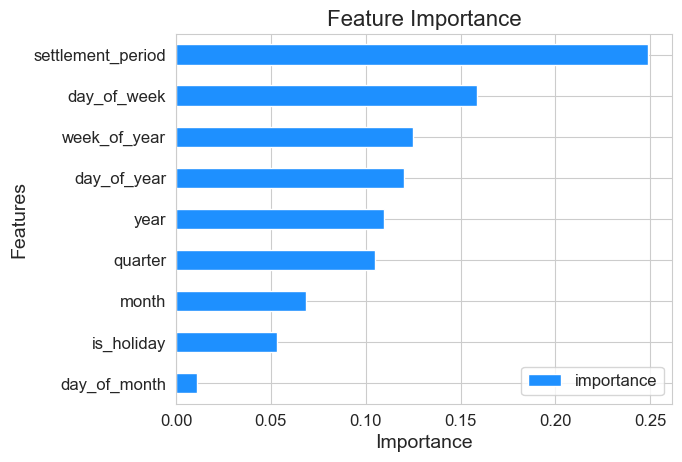

In [54]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh", color="#1E90FF")  # Change color to sky blue

plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.savefig("important_features.png", dpi=300, bbox_inches="tight")
plt.show()

#### Forecast on test set



In [56]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

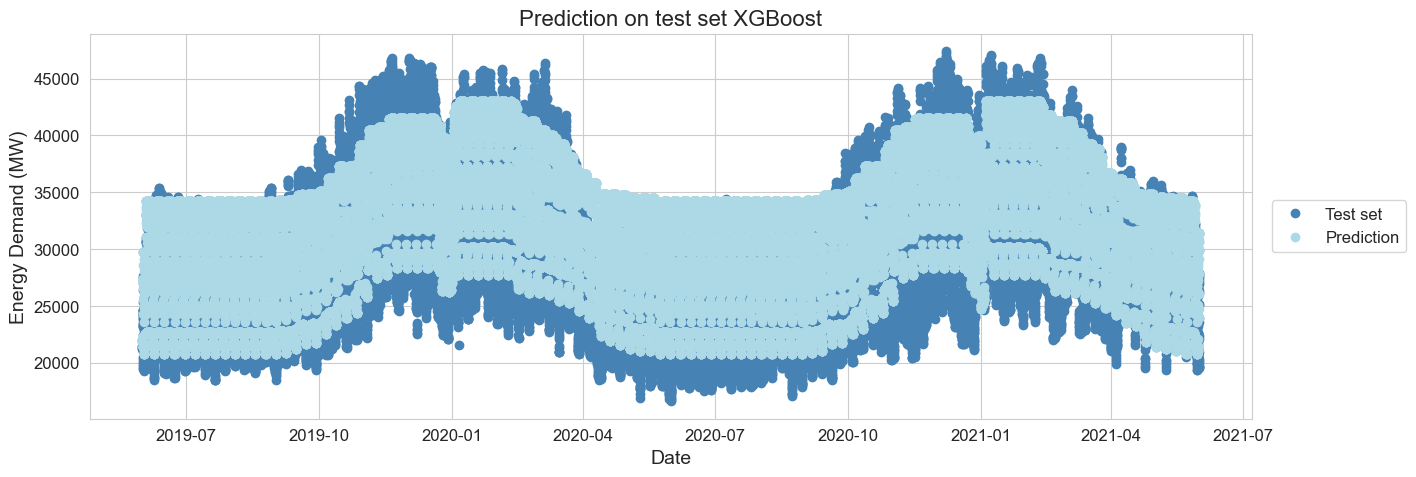

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot test set with blue color
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set", color="#4682B4")

# Plot predictions with orange color
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction", color="#ADD8E6")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set XGBoost")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.savefig("Prediction_test_set_XGBoost.png", dpi=300, bbox_inches="tight")
plt.show()


Text(0.5, 0, 'Date')

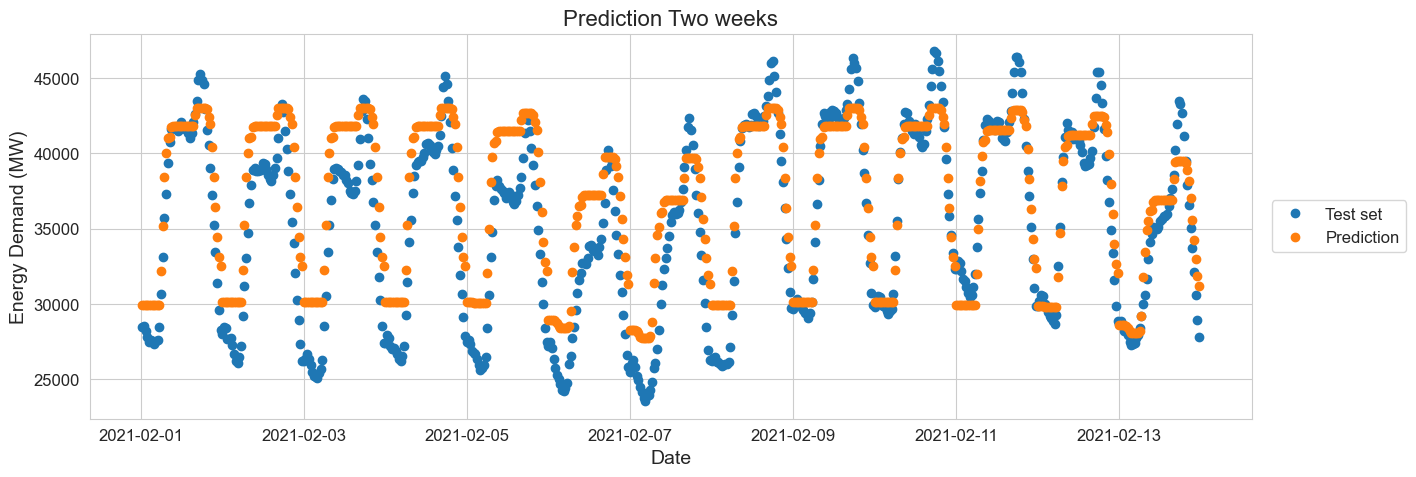

In [58]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set", color="#ADD8E6"
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction", color="#4682B4"
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

In [59]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(
    mean_squared_error(y_test, result_frame["pred_xgb_simple"])
)

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print("Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


## XGBoost with Cross validation and Grid Search



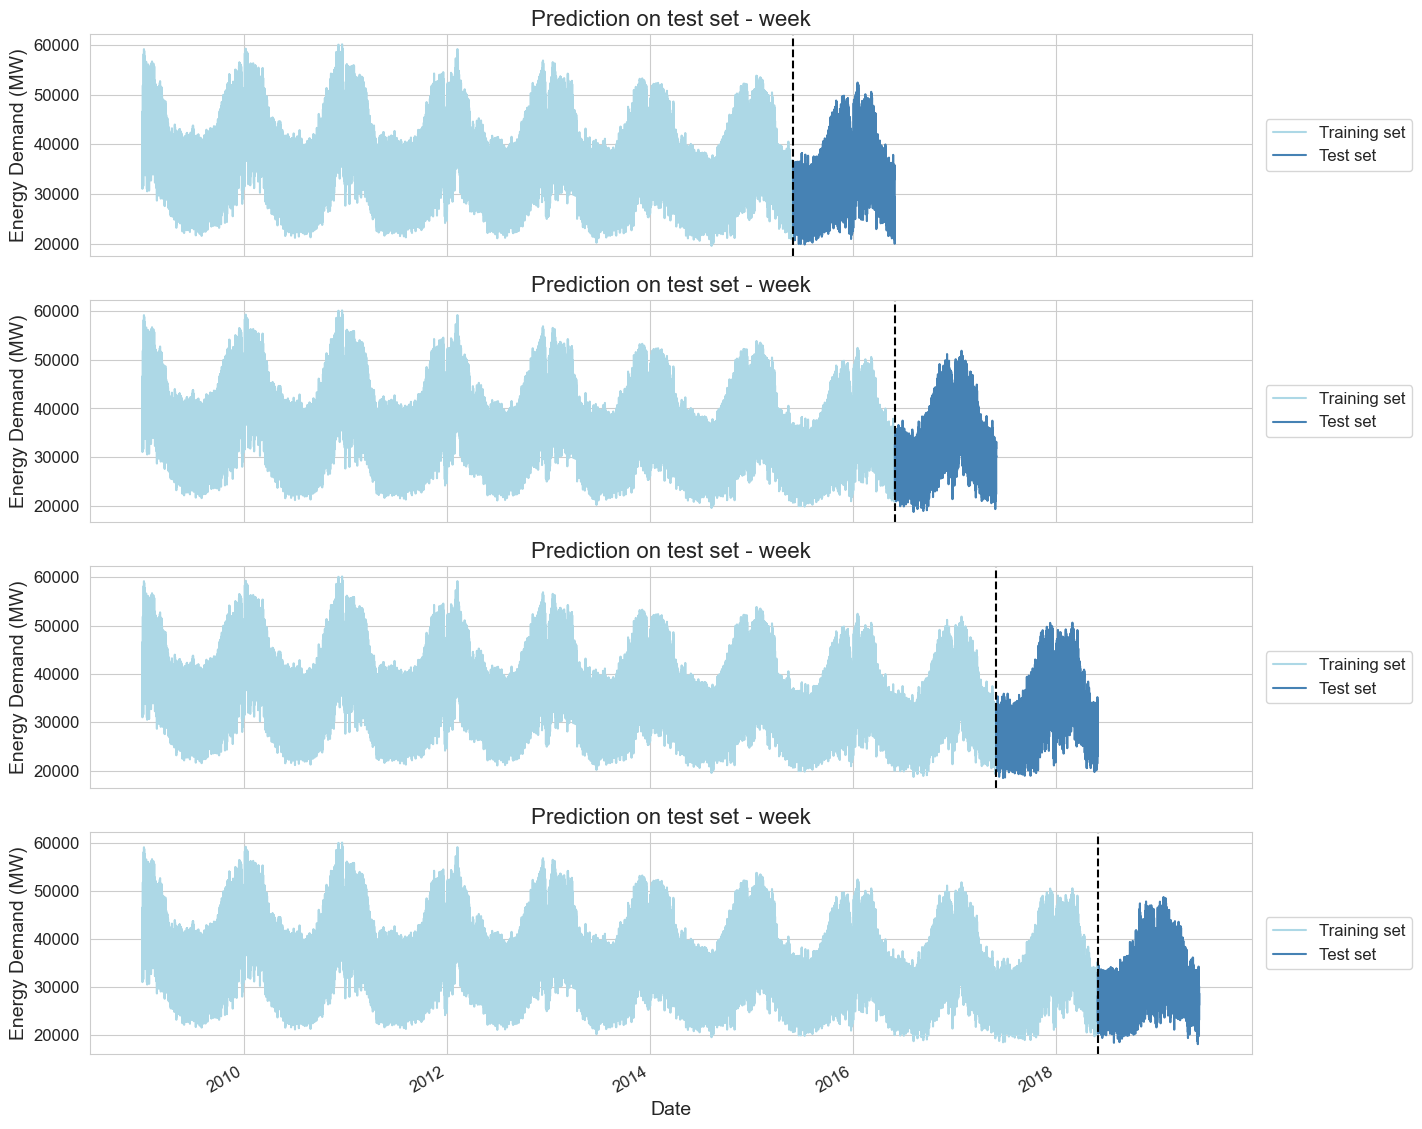

In [78]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index < threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold],
        label="Training set",
        title=f"Data Train-test split fold {fold}",
        color="#ADD8E6"
    )
    test["tsd"].plot(ax=axes[fold], label="Test set", color="#4682B4")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date")
    fold += 1
    plt.savefig("Training_test_split_CV_GS.png", dpi=300, bbox_inches="tight")

One can combine the cross validation technique for time series, called `TimeSeriesSplit` with GridSearchCV to find the best parameters for the XGBoost model.

In [61]:
import warnings


def fxn():
    warnings.warn("FutureWarning", FutureWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [62]:
%%time
from sklearn.model_selection import GridSearchCV

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43, 
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [350, 500, 650], 
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params);

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:29294.42295
[349]	validation_0-rmse:2515.39881
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2043.594 total time=   1.4s
[0]	validation_0-rmse:29296.16607
[349]	validation_0-rmse:2573.75400
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2565.997 total time=   1.3s
[0]	validation_0-rmse:29297.26637
[349]	validation_0-rmse:2591.87160
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2782.546 total time=   1.3s
[0]	validation_0-rmse:29299.47243
[349]	validation_0-rmse:2540.39248
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2330.722 total time=   1.3s
[0]	validation_0-rmse:29294.37741
[349]	validation_0-rmse:2514.26789
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2042.832 total time=   1.1s
[0]	validation_0-rmse:29296.32339
[349]	validation_0-rmse:2579.23450
[CV 2/4] END max_depth=3, n_estimators=350, su

[0]	validation_0-rmse:29298.20589
[499]	validation_0-rmse:2393.03673
[CV 1/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-1988.527 total time=   3.2s
[0]	validation_0-rmse:29300.21360
[499]	validation_0-rmse:2432.89854
[CV 2/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-2389.973 total time=   2.4s
[0]	validation_0-rmse:29302.50296
[499]	validation_0-rmse:2393.22913
[CV 3/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-2438.163 total time=   2.4s
[0]	validation_0-rmse:29302.01434
[499]	validation_0-rmse:2337.89577
[CV 4/4] END max_depth=5, n_estimators=500, subsample=0.95;, score=-2313.292 total time=   2.5s
[0]	validation_0-rmse:29298.22111
[499]	validation_0-rmse:2396.47117
[CV 1/4] END max_depth=5, n_estimators=500, subsample=0.8;, score=-1993.969 total time=   2.1s
[0]	validation_0-rmse:29300.02286
[499]	validation_0-rmse:2436.48733
[CV 2/4] END max_depth=5, n_estimators=500, subsample=0.8;, score=-2393.076 total time=   2.3s
[0]	validati

In [51]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 650, 'subsample': 0.95}

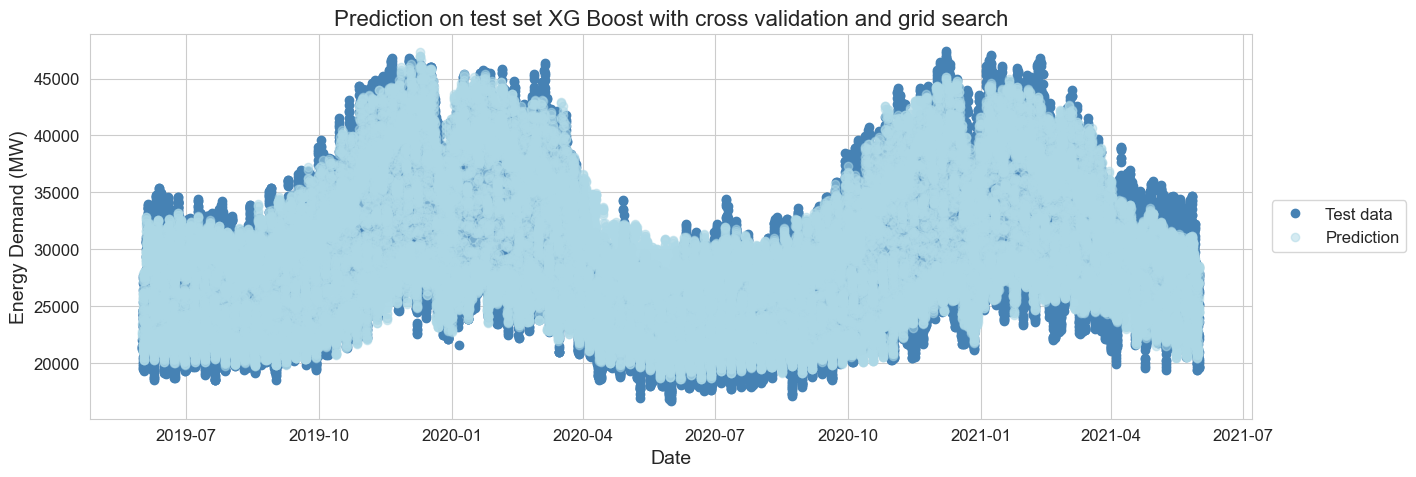

In [77]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data", color="#4682B4")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5, color="#ADD8E6"
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set XG Boost with cross validation and grid search")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.savefig("XGboost_CV_GS_Prediction.png", dpi=300, bbox_inches="tight")

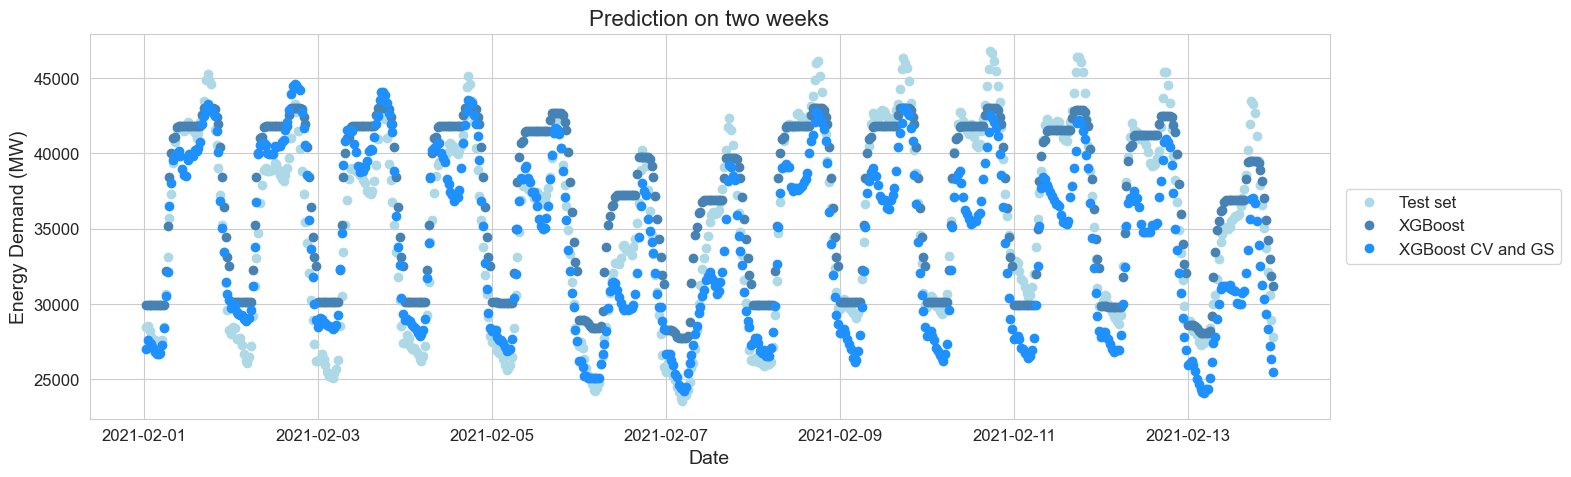

In [68]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set", color="#ADD8E6"
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="XGBoost", color="#4682B4"
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="XGBoost CV and GS",color="#1E90FF"
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.savefig("Prediction_on_Two_weeks.png", dpi=300, bbox_inches="tight")

In [69]:
mape_xgboost_cv = mean_absolute_percentage_error(y_test, result_frame["pred_xgb_cv_gs"])

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.38
Root Mean Squared Error of the cross-validated model is: 2678.23 MW


### Prediction into the future


In [71]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
)

[0]	validation_0-rmse:33486.23395
[100]	validation_0-rmse:12501.65689
[200]	validation_0-rmse:5084.41238
[300]	validation_0-rmse:2751.49449
[400]	validation_0-rmse:2140.00197
[500]	validation_0-rmse:1953.68496
[600]	validation_0-rmse:1874.14262
[649]	validation_0-rmse:1847.70501


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=650, n_jobs=-1,
             num_parallel_tree=None, random_state=43, ...)

dataframe for future:

In [72]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2
        + np.array(df.index.minute.to_list()) / 30
        + 1
    ).astype(int)

    df["settlement_period"] = settlement_period_array

    return df

In [73]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction[
    "settlement_date"
].apply(lambda x: pd.to_datetime(x) in holiday_dates_observed)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction[
    "is_holiday"
].astype(int)

df_and_future_wprediction.tail()

,unnamed: 0,period_hour,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future,settlement_date
2024-10-24 21:30:00,NaN,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,298,4,10,2024,43,30167.0,30937.0,30676.0,True,2024-10-24
2024-10-24 22:00:00,NaN,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,298,4,10,2024,43,28674.0,29872.0,28947.0,True,2024-10-24
2024-10-24 22:30:00,NaN,NaN,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,298,4,10,2024,43,27156.0,28397.0,27583.0,True,2024-10-24
2024-10-24 23:00:00,NaN,NaN,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,298,4,10,2024,43,25435.0,24870.0,25977.0,True,2024-10-24
2024-10-24 23:30:00,NaN,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,298,4,10,2024,43,24257.0,23211.0,24540.0,True,2024-10-24


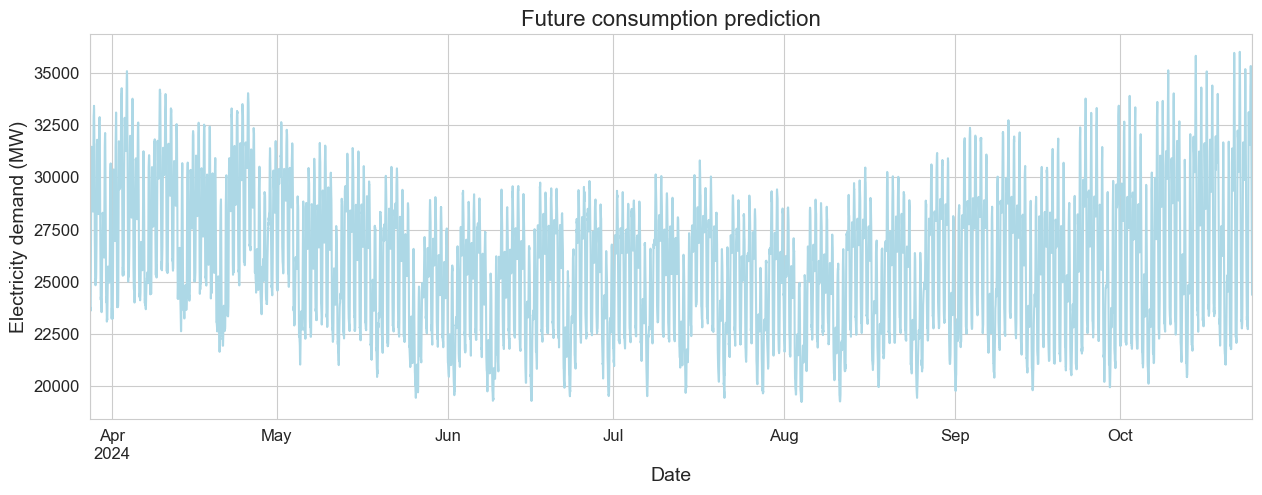

In [81]:
# Assuming you have imported necessary libraries and defined your DataFrame and model predictions earlier

# Make predictions
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(df_and_future_wprediction[FEATURES_CV])

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the predicted values with a different color
df_and_future_wprediction["pred_xgboost"].plot(style="-", ax=ax, color="#ADD8E6")  # Change color here

# Set labels and title
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future consumption prediction")
plt.savefig("Future_consumption_prediction.png", dpi=300, bbox_inches="tight")
plt.show()
